<a href="https://colab.research.google.com/github/brianmulyadi/Designing-Data-Products/blob/main/pass_bill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Start by connecting gdrive into the google colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from datetime import datetime
from datetime import date

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('drive/MyDrive/bigML_115_Rep.csv', parse_dates=True, index_col=0, header=0)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7394 entries, 0 to 7393
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   policyArea         7351 non-null   object 
 1   issponsorPartyR    7394 non-null   int64  
 2   cosponsors         7394 non-null   int64  
 3   cosponsorsRep      7394 non-null   float64
 4   billStatus         7394 non-null   int64  
 5   leadershipRole     7394 non-null   int64  
 6   dwNominate         7394 non-null   float64
 7   seniority          7394 non-null   int64  
 8   votesAgainstParty  7394 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 577.7+ KB


In [10]:
df.describe()

,issponsorPartyR,cosponsors,cosponsorsRep,billStatus,leadershipRole,dwNominate,seniority,votesAgainstParty
count,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000
mean,0.525156,15.429402,0.555762,0.134974,0.216121,0.065975,11.787666,4.657073
std,0.499401,34.040479,0.421360,0.341719,0.411626,0.451404,9.634513,3.516017
min,0.000000,0.000000,-1.000000,0.000000,0.000000,-0.702000,2.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,-0.387000,6.000000,2.740000
50%,1.000000,4.000000,0.600000,0.000000,0.000000,0.215000,8.000000,3.600000
75%,1.000000,14.000000,1.000000,0.000000,0.000000,0.496000,16.000000,5.560000
max,1.000000,385.000000,1.000000,1.000000,1.000000,0.931000,54.000000,38.730000


In [11]:
# sns.countplot(x=raw_data['billStatus'])
# sns.countplot(y=raw_data['policyArea'], order = raw_data['policyArea'].value_counts().index)

In [12]:
# create dummy variables for policy area
df['policyArea'] = df['policyArea'].fillna('Other')
df = pd.get_dummies(df,columns=['policyArea'])
df.head()

,issponsorPartyR,cosponsors,cosponsorsRep,billStatus,leadershipRole,dwNominate,seniority,votesAgainstParty,policyArea_Agriculture and Food,policyArea_Animals,...,policyArea_Native Americans,policyArea_Other,policyArea_Public Lands and Natural Resources,"policyArea_Science, Technology, Communications",policyArea_Social Sciences and History,policyArea_Social Welfare,policyArea_Sports and Recreation,policyArea_Taxation,policyArea_Transportation and Public Works,policyArea_Water Resources Development
0,1,24,1.000000,1,0,0.518,22,1.47,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,1.000000,1,0,0.590,14,4.74,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,16,1.000000,1,1,0.462,12,1.43,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,15,0.533333,1,1,0.374,18,3.49,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,25,0.960000,1,1,0.496,26,1.95,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# get list of feature columns
featureDf= df.loc[:, ~df.columns.isin(['billStatus'])]
featureDf.head()
feature_cols = featureDf.columns.values.tolist()
del featureDf
print(feature_cols)

['issponsorPartyR', 'cosponsors', 'cosponsorsRep', 'leadershipRole', 'dwNominate', 'seniority', 'votesAgainstParty', 'policyArea_Agriculture and Food', 'policyArea_Animals', 'policyArea_Armed Forces and National Security', 'policyArea_Arts, Culture, Religion', 'policyArea_Civil Rights and Liberties, Minority Issues', 'policyArea_Commerce', 'policyArea_Congress', 'policyArea_Crime and Law Enforcement', 'policyArea_Economics and Public Finance', 'policyArea_Education', 'policyArea_Emergency Management', 'policyArea_Energy', 'policyArea_Environmental Protection', 'policyArea_Families', 'policyArea_Finance and Financial Sector', 'policyArea_Foreign Trade and International Finance', 'policyArea_Government Operations and Politics', 'policyArea_Health', 'policyArea_Housing and Community Development', 'policyArea_Immigration', 'policyArea_International Affairs', 'policyArea_Labor and Employment', 'policyArea_Law', 'policyArea_Native Americans', 'policyArea_Other', 'policyArea_Public Lands and 

In [15]:
# replace NaN and inf in the dataset
df['billStatus'] = df['billStatus'].fillna(0)
df['billStatus'].replace([np.inf, -np.inf], 0, inplace = True)
df['cosponsorsRep'].replace(np.inf, 0, inplace = True) # change to cosponsorsRep for 115 and cosponsorsDem for 117


In [18]:
# check which row has infinite numbers
# x = 0
# for row in np.isfinite(df['cosponsorsDem']):
#   x += 1
#   if row == False:
#     print(x)

In [19]:
# output to file for dataset check before running models
# df.to_csv("/for_test.csv")

In [49]:
# feature_cols = ['issponsorPartyD','cosponsors','cosponsorsDem','cosponsorsRep','leadershipRole','dwNominate','seniority']
from sklearn.model_selection import train_test_split

x = df[feature_cols]
y = df.billStatus

# split into train-test data

x_train, x_test, y_train, y_test = train_test_split(x,y, 
                                   test_size=0.25, 
                                   shuffle=True)

In [51]:
# get a rough idea of train test proportion
print(y_train.sum())
print(y_train.count())
print("Ratio of passed:", round(y_train.sum()/y_train.count(),3))
print(y_test.sum())
print(y_test.count())

763
5545
Ratio of passed: 0.138
235
1849


# Logistic Regression

In [60]:
log = LogisticRegression(max_iter=1500)
log.fit(x_train, y_train)
y_pred = log.predict(x_test)

In [62]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8739859383450513
Recall: 0.05106382978723404
[[1604   10]
 [ 223   12]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1614
           1       0.55      0.05      0.09       235

    accuracy                           0.87      1849
   macro avg       0.71      0.52      0.51      1849
weighted avg       0.84      0.87      0.83      1849



In [63]:
auc = metrics.roc_auc_score(y_test, y_pred)
print(auc)

0.5224340214611511


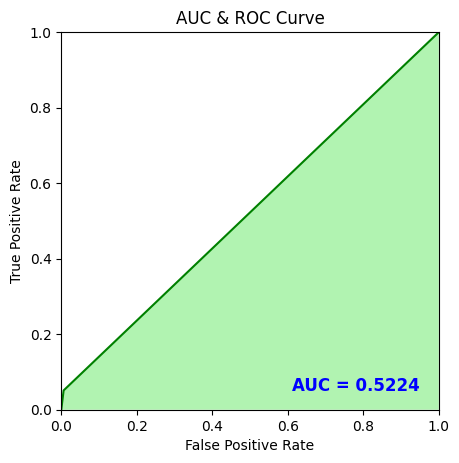

In [64]:
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Decision Tree

In [52]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

In [53]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Max Depth:",clf.tree_.max_depth)
print("Node Count:",clf.tree_.node_count)

Accuracy: 0.8280151433207139
Recall: 0.37872340425531914
[[1442  172]
 [ 146   89]]
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1614
           1       0.34      0.38      0.36       235

    accuracy                           0.83      1849
   macro avg       0.62      0.64      0.63      1849
weighted avg       0.84      0.83      0.83      1849

Max Depth: 29
Node Count: 1741


In [54]:
auc = metrics.roc_auc_score(y_test, y_pred)
print(auc)

0.6360779350892458


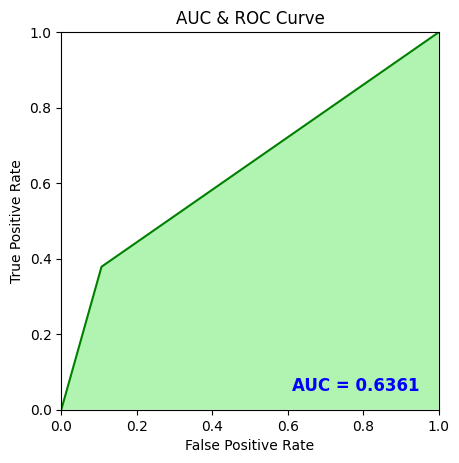

In [55]:
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Random Forest

In [73]:
forest = RandomForestClassifier(n_estimators = 10)
forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)

In [74]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8702001081665766
Recall: 0.2297872340425532
[[1555   59]
 [ 181   54]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1614
           1       0.48      0.23      0.31       235

    accuracy                           0.87      1849
   macro avg       0.69      0.60      0.62      1849
weighted avg       0.84      0.87      0.85      1849



In [75]:
auc = metrics.roc_auc_score(y_test, y_pred)
print(auc)

0.5966160457697277


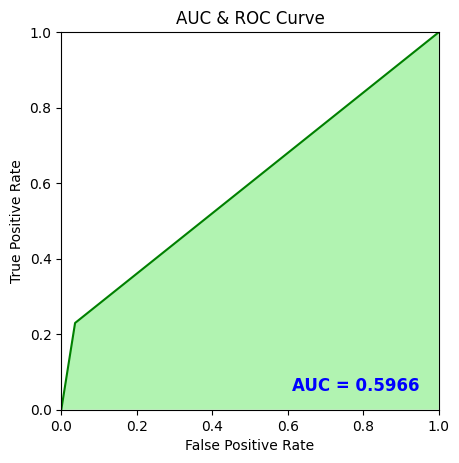

In [76]:
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [23]:
# using graphviz
# import graphviz

# dot_data = tree.export_graphviz(clf, out_file=None)
# graph = graphviz.Source(dot_data)
# graph

In [79]:
# plt.figure(figsize=(10,10))
# a = plot_tree(clf, 
#               feature_names=feature_cols, 
#               class_names=True, 
#               filled=True, 
#               rounded=True, 
#               fontsize=14)